Scaling down `overall_rating` to 3-class and creates in `satisfaction_class`

In [19]:
import pandas as pd
import os

input_file = "/content/drive/MyDrive/PR_Sky/Dataset/airline.csv"
output_folder = "/content/drive/MyDrive/PR_Sky"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

data = pd.read_csv(input_file)

data["overall_rating"] = pd.to_numeric(data["overall_rating"], errors="coerce")

data = data.dropna(subset=["overall_rating"])

satisfaction = []

for r in data["overall_rating"]:
    if r <= 4:
        satisfaction.append(0)
    elif r <= 7:
        satisfaction.append(1)
    else:
        satisfaction.append(2)

data["satisfaction_class"] = satisfaction

output_file = output_folder + "/airline_with_target.csv"
data.to_csv(output_file, index=False)

print("Final dataset shape:", data.shape)

print("\nClass distribution (counts):")
print(data["satisfaction_class"].value_counts().sort_index())

print("\nClass distribution (proportion):")
print(data["satisfaction_class"].value_counts(normalize=True).sort_index().round(3))

print("\nSaved:", output_file)

Final dataset shape: (36861, 21)

Class distribution (counts):
satisfaction_class
0    12571
1     7688
2    16602
Name: count, dtype: int64

Class distribution (proportion):
satisfaction_class
0    0.341
1    0.209
2    0.450
Name: proportion, dtype: float64

Saved: /content/drive/MyDrive/PR_Sky/airline_with_target.csv


Load & sanity check (NO training yet)

In [20]:
import pandas as pd
import numpy as np
import os

base_path = "/content/drive/MyDrive/PR_Sky"
file_name = "airline_with_target.csv"
input_path = base_path + "/" + file_name

data = pd.read_csv(input_path)

if "satisfaction_class" not in data.columns:
    print("no satisfaction_class column, create it from overall_rating first")
    raise SystemExit()

data["satisfaction_class"] = pd.to_numeric(data["satisfaction_class"], errors="coerce")

bad_rows = []
for i in range(len(data)):
    val = data["satisfaction_class"].iloc[i]
    if pd.isna(val) or (val not in [0, 1, 2]):
        bad_rows.append(i)

if len(bad_rows) > 0:
    data = data.drop(bad_rows)

print("Shape:", data.shape)
print("Columns:", list(data.columns))

print("\nClass distribution (counts):")
print(data["satisfaction_class"].value_counts().sort_index())

print("\nClass distribution (proportions):")
print(data["satisfaction_class"].value_counts(normalize=True).sort_index().round(3))

possible_cols = [
    "seat_comfort_rating",
    "cabin_staff_rating",
    "food_beverages_rating",
    "inflight_entertainment_rating",
    "ground_service_rating",
    "wifi_connectivity_rating",
    "value_money_rating"
]

numeric_cols = []
for c in possible_cols:
    if c in data.columns:
        numeric_cols.append(c)

if len(numeric_cols) == 0:
    print("no numeric rating columns found! Please check the dataset.")
    raise SystemExit()

print("\nNumeric features to use (excluding overall_rating):", numeric_cols)

for c in numeric_cols:
    data[c] = pd.to_numeric(data[c], errors="coerce")

missing_percents = {}
for c in numeric_cols:
    total = len(data)
    missing = data[c].isna().sum()
    percent = missing / total
    missing_percents[c] = percent

print("\nMissingness (numeric features):")
for c in sorted(missing_percents, key=missing_percents.get, reverse=True):
    print(c, ":", round(missing_percents[c], 3))

too_missing = []
for c in numeric_cols:
    if missing_percents[c] > 0.5:
        too_missing.append(c)

if len(too_missing) > 0:
    print("\nNOTE: These features have >50% missing values and may hurt GNB:")
    print(too_missing)
    print("You can drop them later or fill missing values before training")

print("\nSample rows (head):")
cols_to_show = ["satisfaction_class"] + numeric_cols
print(data[cols_to_show].head(10))

output_file = base_path + "/airline_with_target__checked.csv"
data.to_csv(output_file, index=False)
print("\nSaving checked dataset to:", output_file)

Shape: (36861, 21)
Columns: ['airline_name', 'link', 'title', 'author', 'author_country', 'date', 'content', 'aircraft', 'type_traveller', 'cabin_flown', 'route', 'overall_rating', 'seat_comfort_rating', 'cabin_staff_rating', 'food_beverages_rating', 'inflight_entertainment_rating', 'ground_service_rating', 'wifi_connectivity_rating', 'value_money_rating', 'recommended', 'satisfaction_class']

Class distribution (counts):
satisfaction_class
0    12571
1     7688
2    16602
Name: count, dtype: int64

Class distribution (proportions):
satisfaction_class
0    0.341
1    0.209
2    0.450
Name: proportion, dtype: float64

Numeric features to use (excluding overall_rating): ['seat_comfort_rating', 'cabin_staff_rating', 'food_beverages_rating', 'inflight_entertainment_rating', 'ground_service_rating', 'wifi_connectivity_rating', 'value_money_rating']

Missingness (numeric features):
wifi_connectivity_rating : 0.985
ground_service_rating : 0.94
inflight_entertainment_rating : 0.23
food_beverag

Preprocessing & Feature Engineering

In [21]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

base_path = "/content/drive/MyDrive/PR_Sky"
input_file = base_path + "/airline_with_target__checked.csv"
output_folder = base_path

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

data = pd.read_csv(input_file)

target = "satisfaction_class"

possible = [
    "seat_comfort_rating",
    "cabin_staff_rating",
    "food_beverages_rating",
    "inflight_entertainment_rating",
    "ground_service_rating",
    "wifi_connectivity_rating",
    "value_money_rating"
]

features = []
for c in possible:
    if c in data.columns:
        features.append(c)

X = data[features]
y = pd.to_numeric(data[target], errors="coerce").astype(int)

imputer = SimpleImputer(strategy="median")
X_new = imputer.fit_transform(X)
X_new = pd.DataFrame(X_new, columns=features)

print("\nClass distribution (counts):")
print(y.value_counts().sort_index())

print("\nClass distribution (proportions):")
print((y.value_counts(normalize=True).sort_index()).round(3))

X_train, X_test, y_train, y_test = train_test_split(
    X_new, y, test_size=0.20, random_state=42, stratify=y
)

print("\nShapes: X_train:", X_train.shape, "X_test:", X_test.shape)

train = X_train.copy()
train[target] = y_train
test = X_test.copy()
test[target] = y_test

train_file = output_folder + "/airline_train_proc.csv"
test_file = output_folder + "/airline_test_proc.csv"

train.to_csv(train_file, index=False)
test.to_csv(test_file, index=False)

print("\nSaved preprocessed datasets:")
print(" - Train:", train_file)
print(" - Test :", test_file)


Class distribution (counts):
satisfaction_class
0    12571
1     7688
2    16602
Name: count, dtype: int64

Class distribution (proportions):
satisfaction_class
0    0.341
1    0.209
2    0.450
Name: proportion, dtype: float64

Shapes: X_train: (29488, 7) X_test: (7373, 7)

Saved preprocessed datasets:
 - Train: /content/drive/MyDrive/PR_Sky/airline_train_proc.csv
 - Test : /content/drive/MyDrive/PR_Sky/airline_test_proc.csv


Gaussian Naive Bayes

now i load train and test csv
Train shape: (29488, 7)  Test shape: (7373, 7)
Classes in y_train: [np.int64(0), np.int64(1), np.int64(2)]
Classes in y_test : [np.int64(0), np.int64(1), np.int64(2)]
now i make gaussian nb model and fit
now i do prediction on test data
now i calculate all metrics

=== GaussianNB (Airline) — Test Metrics ===
Accuracy          : 0.7351
Macro F1          : 0.7121
Log-loss          : 0.8754
Brier (multiclass): 0.115696

=== Classification Report ===
              precision    recall  f1-score   support

           0     0.8594    0.8119    0.8349      2514
           1     0.4259    0.6151    0.5033      1538
           2     0.8761    0.7326    0.7980      3321

    accuracy                         0.7351      7373
   macro avg     0.7205    0.7198    0.7121      7373
weighted avg     0.7765    0.7351    0.7491      7373


Confusion Matrix (counts) [rows=true, cols=pred]:
 [[2041  454   19]
 [ 267  946  325]
 [  67  821 2433]]


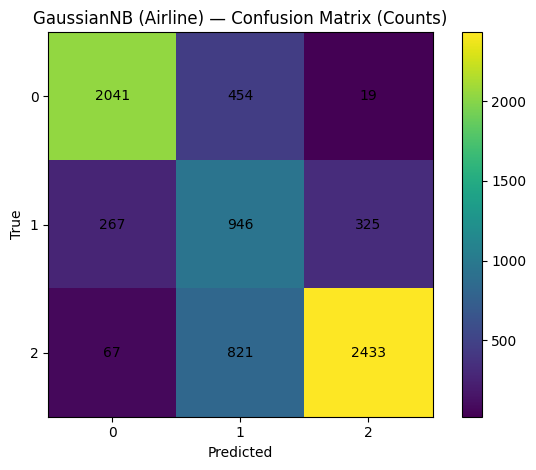

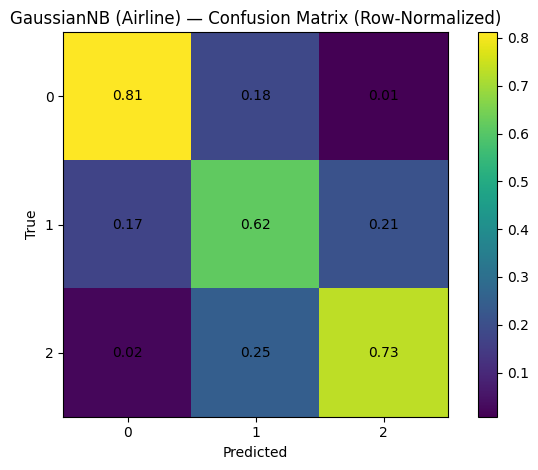

In [7]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report, confusion_matrix

BASE_DIR = "/content/drive/MyDrive/PR_Sky"
TRAIN_CSV = os.path.join(BASE_DIR, "airline_train_proc.csv")
TEST_CSV  = os.path.join(BASE_DIR, "airline_test_proc.csv")
target_col = "satisfaction_class"

print("now i load train and test csv")
train = pd.read_csv(TRAIN_CSV)
test  = pd.read_csv(TEST_CSV)

X_train = train.drop(columns=[target_col]).copy()
y_train = train[target_col].astype(int).copy()
X_test  = test.drop(columns=[target_col]).copy()
y_test  = test[target_col].astype(int).copy()

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)
print("Classes in y_train:", sorted(np.unique(y_train)))
print("Classes in y_test :", sorted(np.unique(y_test)))

print("now i make gaussian nb model and fit")
gnb = GaussianNB()
gnb.fit(X_train, y_train)

print("now i do prediction on test data")
y_pred  = gnb.predict(X_test)
y_proba = gnb.predict_proba(X_test)

print("now i calculate all metrics")
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
ll = log_loss(y_test, y_proba, labels=gnb.classes_)

classes = gnb.classes_

class_to_index = {}
idx = 0
for c in classes:
    class_to_index[c] = idx
    idx = idx + 1

y_true_onehot = np.zeros(y_proba.shape)

for i in range(len(y_test)):
    yi = y_test.iloc[i]
    if yi in class_to_index:
        j = class_to_index[yi]
        y_true_onehot[i, j] = 1.0

brier_multiclass = np.mean((y_proba - y_true_onehot) ** 2)

print("\n=== GaussianNB (Airline) — Test Metrics ===")
print("Accuracy          : {:.4f}".format(acc))
print("Macro F1          : {:.4f}".format(f1_macro))
print("Log-loss          : {:.4f}".format(ll))
print("Brier (multiclass): {:.6f}".format(brier_multiclass))

print("\n=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=classes)

print("\nConfusion Matrix (counts) [rows=true, cols=pred]:\n", cm)

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("GaussianNB (Airline) — Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.show()

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure()
plt.imshow(cm_norm, interpolation='nearest')
plt.title("GaussianNB (Airline) — Confusion Matrix (Row-Normalized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        txt = "{:.2f}".format(cm_norm[i, j])
        plt.text(j, i, txt, ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.show()

# Path way to Multinomial Naive Bayes

Load & Target Check

In [9]:
import os
import pandas as pd
import numpy as np

BASE = "/content/drive/MyDrive/PR_Sky"
IN_CSV = os.path.join(BASE, "airline_with_target.csv")

df = pd.read_csv(IN_CSV)

if "satisfaction_class" not in df.columns:
    print("Missing satisfaction_class column, please run target creation first")
    raise SystemExit()

if "content" not in df.columns:
    print("Missing content text column, cannot do multinomial nb path")
    raise SystemExit()

df["content"] = df["content"].astype(str).str.strip()

df = df.dropna(subset=["satisfaction_class"])

df = df[df["content"].str.len() > 0]

df["satisfaction_class"] = pd.to_numeric(df["satisfaction_class"], errors="coerce")

valid_values = [0, 1, 2]
mask_list = []
for i in range(len(df)):
    v = df["satisfaction_class"].iloc[i]
    if v in valid_values:
        mask_list.append(True)
    else:
        mask_list.append(False)
df = df[mask_list]

print("Shape after filtering:", df.shape)

print("\nClass distribution (counts):")
print(df["satisfaction_class"].value_counts().sort_index())

print("\nClass distribution (proportions):")
print(df["satisfaction_class"].value_counts(normalize=True).sort_index().round(3))

CHECKED_CSV = os.path.join(BASE, "airline_text_checked.csv")
df.to_csv(CHECKED_CSV, index=False)
print("\nSaved :", CHECKED_CSV)

Shape after filtering: (36861, 21)

Class distribution (counts):
satisfaction_class
0    12571
1     7688
2    16602
Name: count, dtype: int64

Class distribution (proportions):
satisfaction_class
0    0.341
1    0.209
2    0.450
Name: proportion, dtype: float64

Saved : /content/drive/MyDrive/PR_Sky/airline_text_checked.csv


Text Preprocessing → Train/Test split → Word2Vec → KMeans BoC

In [10]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 42.8 MB/s eta 0:00:00


In [11]:
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from tqdm import tqdm

BASE = "/content/drive/MyDrive/PR_Sky"
IN_CSV = os.path.join(BASE, "airline_text_checked.csv")

df = pd.read_csv(IN_CSV)

_word_re = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")

all_tokens = []
for i in range(len(df)):
    text_here = df["content"].iloc[i]
    text_here = str(text_here).lower()
    words_here = _word_re.findall(text_here)
    all_tokens.append(words_here)

df["tokens"] = all_tokens

keep_mask = []
for i in range(len(df)):
    if len(df["tokens"].iloc[i]) > 0:
        keep_mask.append(True)
    else:
        keep_mask.append(False)

df = df[keep_mask].copy()

y = df["satisfaction_class"].astype(int).values

tokens_list = df["tokens"].tolist()
X_train_tokens, X_test_tokens, y_train, y_test = train_test_split(
    tokens_list, y, test_size=0.20, random_state=42, stratify=y
)

print("Train docs:", len(X_train_tokens), "  Test docs:", len(X_test_tokens))

w2v = Word2Vec(
    sentences=X_train_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=0,
    epochs=10
)

print("Word2Vec vocab size:", len(w2v.wv))

vocab_words = list(w2v.wv.index_to_key)

if len(vocab_words) > 0:
    word_vecs_list = []
    for w in vocab_words:
        word_vecs_list.append(w2v.wv[w])
    word_vecs = np.vstack(word_vecs_list)
else:
    word_vecs = np.zeros((0, 100))

if len(vocab_words) > 0:
    K_temp = len(vocab_words) // 5
    if K_temp < 50:
        K_temp = 50
    if K_temp > 300:
        K_temp = 300
    K = K_temp
else:
    K = 50

print("Clustering " + str(len(vocab_words)) + " word vectors into K=" + str(K) + " clusters...")

word2cluster = {}
if len(vocab_words) > 0:
    kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
    kmeans.fit(word_vecs)
    labels_array = kmeans.labels_
    idx = 0
    while idx < len(vocab_words):
        w = vocab_words[idx]
        c = labels_array[idx]
        word2cluster[w] = int(c)
        idx = idx + 1

train_boc_list = []
for tokens in tqdm(X_train_tokens, desc="Train BoC"):
    v = np.zeros(K, dtype=np.int32)
    for t in tokens:
        if t in word2cluster:
            cid = word2cluster[t]
            if cid >= 0 and cid < K:
                v[cid] = v[cid] + 1
    train_boc_list.append(v)

X_train_boc = np.vstack(train_boc_list)

test_boc_list = []
for tokens in tqdm(X_test_tokens, desc="Test BoC"):
    v = np.zeros(K, dtype=np.int32)
    for t in tokens:
        if t in word2cluster:
            cid = word2cluster[t]
            if cid >= 0 and cid < K:
                v[cid] = v[cid] + 1
    test_boc_list.append(v)

X_test_boc = np.vstack(test_boc_list)

print("X_train_boc shape:", X_train_boc.shape, " X_test_boc shape:", X_test_boc.shape)

np.save(os.path.join(BASE, "airline_X_train_boc.npy"), X_train_boc)
np.save(os.path.join(BASE, "airline_X_test_boc.npy"), X_test_boc)
np.save(os.path.join(BASE, "airline_y_train.npy"), y_train)
np.save(os.path.join(BASE, "airline_y_test.npy"), y_test)

cluster_map_path = os.path.join(BASE, "airline_word2cluster.tsv")
f = open(cluster_map_path, "w", encoding="utf-8")
f.write("word\tcluster\n")
for w in vocab_words:
    line = w + "\t" + str(word2cluster[w]) + "\n"
    f.write(line)
f.close()

print("\nSaved:")
print(" - ", os.path.join(BASE, "airline_X_train_boc.npy"))
print(" - ", os.path.join(BASE, "airline_X_test_boc.npy"))
print(" - ", os.path.join(BASE, "airline_y_train.npy"))
print(" - ", os.path.join(BASE, "airline_y_test.npy"))
print(" - ", cluster_map_path)

Train docs: 29488   Test docs: 7373
Word2Vec vocab size: 17202
Clustering 17202 word vectors into K=300 clusters...


Test BoC: 100%|██████████| 7373/7373 [00:00<00:00, 9999.60it/s] 


X_train_boc shape: (29488, 300)  X_test_boc shape: (7373, 300)

Saved:
 -  /content/drive/MyDrive/PR_Sky/airline_X_train_boc.npy
 -  /content/drive/MyDrive/PR_Sky/airline_X_test_boc.npy
 -  /content/drive/MyDrive/PR_Sky/airline_y_train.npy
 -  /content/drive/MyDrive/PR_Sky/airline_y_test.npy
 -  /content/drive/MyDrive/PR_Sky/airline_word2cluster.tsv


Multinomial Naive Bayes Train + Evaluate

Shapes: (29488, 300) (7373, 300) (29488,) (7373,)

Best alpha: 2.0
Accuracy  : 0.6577
Macro F1  : 0.6063
Log-loss  : 1.8926

=== Classification Report (best alpha) ===
              precision    recall  f1-score   support

           0     0.7104    0.6830    0.6964      2514
           1     0.3767    0.3537    0.3649      1538
           2     0.7369    0.7793    0.7575      3321

    accuracy                         0.6577      7373
   macro avg     0.6080    0.6053    0.6063      7373
weighted avg     0.6527    0.6577    0.6548      7373


Confusion Matrix (counts) [rows=true, cols=pred]:
 [[1717  510  287]
 [ 357  544  637]
 [ 343  390 2588]]


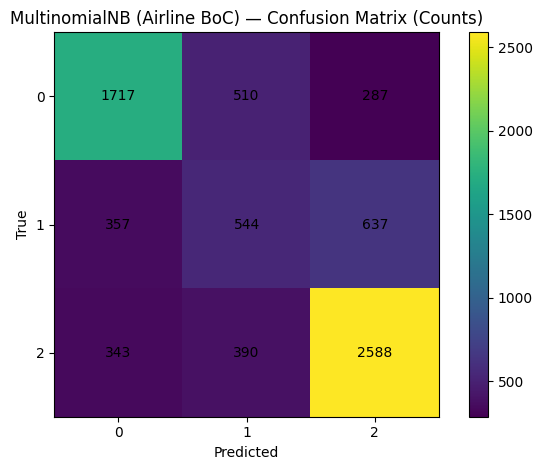

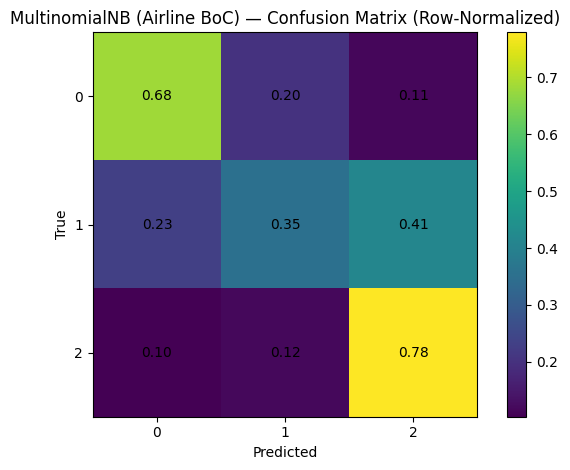

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report, confusion_matrix

BASE = "/content/drive/MyDrive/PR_Sky"

X_train = np.load(os.path.join(BASE, "airline_X_train_boc.npy"))
X_test  = np.load(os.path.join(BASE, "airline_X_test_boc.npy"))
y_train = np.load(os.path.join(BASE, "airline_y_train.npy"))
y_test  = np.load(os.path.join(BASE, "airline_y_test.npy"))

print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

alphas = [0.05, 0.1, 0.5, 1.0, 2.0]

best_alpha = None
best_acc = None
best_f1 = None
best_logloss = None
best_model = None

for a in alphas:

    clf = MultinomialNB(alpha=a)
    clf.fit(X_train, y_train)

    y_pred_loop = clf.predict(X_test)
    y_proba_loop = clf.predict_proba(X_test)

    acc_loop = accuracy_score(y_test, y_pred_loop)
    f1m_loop = f1_score(y_test, y_pred_loop, average="macro")
    ll_loop = log_loss(y_test, y_proba_loop, labels=clf.classes_)

    if best_alpha is None:
        best_alpha = a
        best_acc = acc_loop
        best_f1 = f1m_loop
        best_logloss = ll_loop
        best_model = clf
    else:

        if ll_loop < best_logloss:
            best_alpha = a
            best_acc = acc_loop
            best_f1 = f1m_loop
            best_logloss = ll_loop
            best_model = clf

print("\nBest alpha: {}".format(best_alpha))
print("Accuracy  : {:.4f}".format(best_acc))
print("Macro F1  : {:.4f}".format(best_f1))
print("Log-loss  : {:.4f}".format(best_logloss))

best_clf = best_model
y_pred = best_clf.predict(X_test)
y_proba = best_clf.predict_proba(X_test)

print("\n=== Classification Report (best alpha) ===")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=best_clf.classes_)
print("\nConfusion Matrix (counts) [rows=true, cols=pred]:\n", cm)

plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.colorbar()
plt.title("MultinomialNB (Airline BoC) — Confusion Matrix (Counts)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(best_clf.classes_)), best_clf.classes_)
plt.yticks(range(len(best_clf.classes_)), best_clf.classes_)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.tight_layout()
plt.show()

cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure()
plt.imshow(cmn, interpolation="nearest")
plt.colorbar()
plt.title("MultinomialNB (Airline BoC) — Confusion Matrix (Row-Normalized)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(best_clf.classes_)), best_clf.classes_)
plt.yticks(range(len(best_clf.classes_)), best_clf.classes_)
for i in range(cmn.shape[0]):
    for j in range(cm.shape[1]):
        txt_here = "{:.2f}".format(cmn[i, j])
        plt.text(j, i, txt_here, ha="center", va="center")
plt.tight_layout()
plt.show()

# Path way to Bernoulli Naive Bayes

Feature Selection + Preprocessing to Binary Matrix

In [13]:
import os
import re
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import csr_matrix, save_npz

BASE = "/content/drive/MyDrive/PR_Sky"
IN_CSV = os.path.join(BASE, "airline_with_target.csv")
OUT_DIR = BASE
os.makedirs(OUT_DIR, exist_ok=True)

df = pd.read_csv(IN_CSV)

if "satisfaction_class" not in df.columns:
    print("Run target creation first.")
    raise SystemExit()

y_all = pd.to_numeric(df["satisfaction_class"], errors="coerce")
df = df[~y_all.isna()].copy()
y_all = y_all.astype(int).values

CANDIDATES = [
    "airline_name",
    "type_traveller",
    "cabin_flown",
    "route",
    "author_country",
    "aircraft",
]

present = []
for c in CANDIDATES:
    if c in df.columns:
        present.append(c)

if len(present) == 0:
    raise ValueError("No categorical features found for BernoulliNB.")

print("Using categorical features:", present)

for c in present:
    new_vals = []
    for v in df[c]:
        if pd.isna(v):
            new_vals.append("unknown")
        else:
            s = str(v)
            s = s.strip().lower()
            s = re.sub(r"\s+", " ", s)
            if s == "":
                new_vals.append("unknown")
            else:
                new_vals.append(s)
    df[c] = new_vals

TOPK = 75
for c in present:
    vc = df[c].value_counts()
    top_values = vc.head(TOPK).index.tolist()
    keep_set = set(top_values)

    new_vals = []
    for v in df[c]:
        if v in keep_set:
            new_vals.append(v)
        else:
            new_vals.append("other")
    df[c] = new_vals

try:
    enc = OneHotEncoder(handle_unknown="ignore", sparse_output=True, dtype=np.uint8)
except TypeError:
    enc = OneHotEncoder(handle_unknown="ignore", sparse=True, dtype=np.uint8)

X_all_sparse = enc.fit_transform(df[present])

feature_names = enc.get_feature_names_out(present).tolist()
featmap_path = os.path.join(OUT_DIR, "airline_bnb_feature_names.json")
with open(featmap_path, "w", encoding="utf-8") as f:
    json.dump(feature_names, f, ensure_ascii=False, indent=2)

print("Binary matrix shape:", X_all_sparse.shape)
print("Saved feature names:", featmap_path)

X_tr, X_te, y_tr, y_te = train_test_split(
    X_all_sparse, y_all, test_size=0.20, random_state=42, stratify=y_all
)

train_npz = os.path.join(OUT_DIR, "airline_BNB_X_train.npz")
test_npz  = os.path.join(OUT_DIR, "airline_BNB_X_test.npz")
save_npz(train_npz, csr_matrix(X_tr))
save_npz(test_npz,  csr_matrix(X_te))

np.save(os.path.join(OUT_DIR, "airline_BNB_y_train.npy"), y_tr)
np.save(os.path.join(OUT_DIR, "airline_BNB_y_test.npy"),  y_te)

print("\nSaved:")
print(" -", train_npz)
print(" -", test_npz)
print(" -", os.path.join(OUT_DIR, "airline_BNB_y_train.npy"))
print(" -", os.path.join(OUT_DIR, "airline_BNB_y_test.npy"))

Using categorical features: ['airline_name', 'type_traveller', 'cabin_flown', 'route', 'author_country', 'aircraft']
Binary matrix shape: (36861, 314)
Saved feature names: /content/drive/MyDrive/PR_Sky/airline_bnb_feature_names.json

Saved:
 - /content/drive/MyDrive/PR_Sky/airline_BNB_X_train.npz
 - /content/drive/MyDrive/PR_Sky/airline_BNB_X_test.npz
 - /content/drive/MyDrive/PR_Sky/airline_BNB_y_train.npy
 - /content/drive/MyDrive/PR_Sky/airline_BNB_y_test.npy


Train, Evaluate, Interpret

Shapes: (29488, 314) (7373, 314) (29488,) (7373,)

Best alpha: 2.0
Accuracy  : 0.5243
Macro F1  : 0.3980
Log-loss  : 1.0111

=== Classification Report (best alpha) ===
              precision    recall  f1-score   support

           0     0.5524    0.4610    0.5026      2514
           1     0.3419    0.0345    0.0626      1538
           2     0.5184    0.7992    0.6288      3321

    accuracy                         0.5243      7373
   macro avg     0.4709    0.4315    0.3980      7373
weighted avg     0.4932    0.5243    0.4677      7373


Confusion Matrix (counts) [rows=true, cols=pred]:
 [[1159   41 1314]
 [ 333   53 1152]
 [ 606   61 2654]]


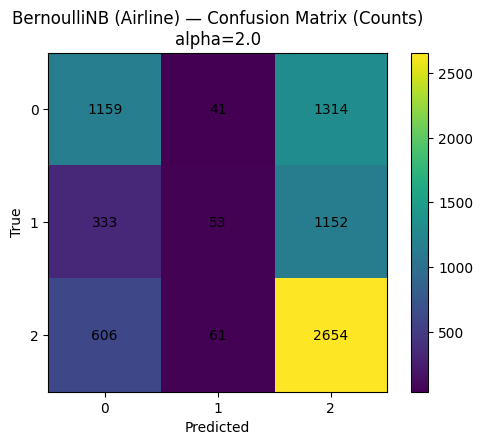

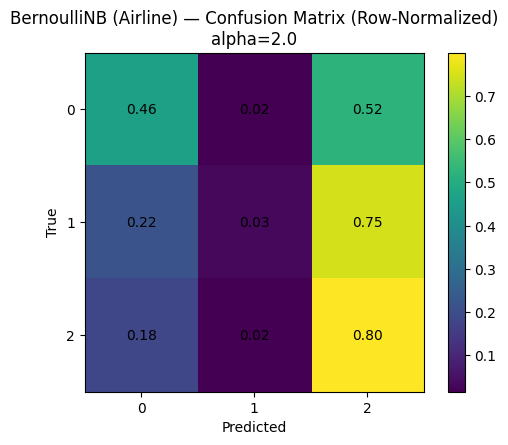


Top 15 features for class=0 (feature, logP(x=1|c), Δ_vs_others):
  airline_name_air-canada-rouge                       -3.038   Δ=+2.276
  airline_name_spirit-airlines                        -2.805   Δ=+2.130
  author_country_unknown                              -2.959   Δ=+1.878
  airline_name_united-airlines                        -3.109   Δ=+1.372
  airline_name_american-airlines                      -3.430   Δ=+1.319
  cabin_flown_unknown                                 -2.287   Δ=+1.167
  airline_name_sunwing-airlines                       -3.933   Δ=+1.128
  airline_name_frontier-airlines                      -4.372   Δ=+1.122
  type_traveller_business                             -4.135   Δ=+0.855
  aircraft_boeing 767-300                             -6.914   Δ=+0.842
  airline_name_allegiant-air                          -4.275   Δ=+0.842
  route_houston to denver                             -7.607   Δ=+0.809
  aircraft_airbus                                     -7.271   Δ=+0.79

In [14]:
import os
import json
import numpy as np
from scipy.sparse import load_npz
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, log_loss, classification_report, confusion_matrix
import matplotlib.pyplot as plt

BASE = "/content/drive/MyDrive/PR_Sky"
XTR = os.path.join(BASE, "airline_BNB_X_train.npz")
XTE = os.path.join(BASE, "airline_BNB_X_test.npz")
ytr = os.path.join(BASE, "airline_BNB_y_train.npy")
yte = os.path.join(BASE, "airline_BNB_y_test.npy")
featmap_path = os.path.join(BASE, "airline_bnb_feature_names.json")

X_train = load_npz(XTR)
X_test  = load_npz(XTE)
y_train = np.load(ytr)
y_test  = np.load(yte)

f = open(featmap_path, "r", encoding="utf-8")
feature_names = json.load(f)
f.close()

print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

alphas = [0.25, 0.5, 1.0, 1.5, 2.0]

best_alpha = None
best_acc = None
best_f1 = None
best_logloss = None
best_model = None

for a in alphas:
    clf = BernoulliNB(alpha=a)
    clf.fit(X_train, y_train)

    y_pred_loop = clf.predict(X_test)
    y_proba_loop = clf.predict_proba(X_test)

    acc_loop = accuracy_score(y_test, y_pred_loop)
    f1m_loop = f1_score(y_test, y_pred_loop, average="macro")
    ll_loop = log_loss(y_test, y_proba_loop, labels=clf.classes_)

    if best_alpha is None:
        best_alpha = a
        best_acc = acc_loop
        best_f1 = f1m_loop
        best_logloss = ll_loop
        best_model = clf
    else:
        if ll_loop < best_logloss:
            best_alpha = a
            best_acc = acc_loop
            best_f1 = f1m_loop
            best_logloss = ll_loop
            best_model = clf

print("\nBest alpha: {}".format(best_alpha))
print("Accuracy  : {:.4f}".format(best_acc))
print("Macro F1  : {:.4f}".format(best_f1))
print("Log-loss  : {:.4f}".format(best_logloss))

best_clf = best_model
y_pred  = best_clf.predict(X_test)
y_proba = best_clf.predict_proba(X_test)

print("\n=== Classification Report (best alpha) ===")
print(classification_report(y_test, y_pred, digits=4))

classes = best_clf.classes_
cm = confusion_matrix(y_test, y_pred, labels=classes)
print("\nConfusion Matrix (counts) [rows=true, cols=pred]:\n", cm)

plt.figure(figsize=(5.5, 4.5))
plt.imshow(cm, interpolation="nearest")
plt.title("BernoulliNB (Airline) — Confusion Matrix (Counts)\nalpha=" + str(best_alpha))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.show()

cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(5.5, 4.5))
plt.imshow(cm_norm, interpolation="nearest")
plt.title("BernoulliNB (Airline) — Confusion Matrix (Row-Normalized)\nalpha=" + str(best_alpha))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(classes)), classes)
plt.yticks(range(len(classes)), classes)
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        txt_val = "{:.2f}".format(cm_norm[i, j])
        plt.text(j, i, txt_val, ha="center", va="center")
plt.colorbar()
plt.tight_layout()
plt.show()

log_prob = best_clf.feature_log_prob_

KSHOW = 15
for i in range(len(classes)):
    class_logp = log_prob[i]

    all_idx = np.arange(log_prob.shape[0])
    other_idx_list = []
    for j in range(len(all_idx)):
        if j != i:
            other_idx_list.append(all_idx[j])
    other_idx = np.array(other_idx_list)

    mean_other = log_prob[other_idx].mean(axis=0)

    delta = class_logp - mean_other

    order = np.argsort(delta)[::-1]
    top_idx = order[:KSHOW]

    print("\nTop " + str(KSHOW) + " features for class=" + str(classes[i]) + " (feature, logP(x=1|c), Δ_vs_others):")
    for j in top_idx:
        name = feature_names[j]
        lp = float(class_logp[j])
        dd = float(delta[j])
        print("  {0:50s}  {1:+.3f}   Δ={2:+.3f}".format(name, lp, dd))

# Path way to Hybrid Model: Combining structured numeric and text features

LOAD DATASET numeric + Text

In [15]:
import os
import re
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

BASE = "/content/drive/MyDrive/PR_Sky"
SRC  = os.path.join(BASE, "airline_with_target.csv")

if not os.path.exists(SRC):
    print("Run target creation first (airline_with_target.csv).")
    raise SystemExit()

df = pd.read_csv(SRC)

if "satisfaction_class" not in df.columns:
    print("satisfaction_class missing.")
    raise SystemExit()

if "content" not in df.columns:
    print("content column missing.")
    raise SystemExit()

df["satisfaction_class"] = pd.to_numeric(df["satisfaction_class"], errors="coerce")

valid_vals = [0, 1, 2]
mask_target = []
for i in range(len(df)):
    v = df["satisfaction_class"].iloc[i]
    if v in valid_vals:
        mask_target.append(True)
    else:
        mask_target.append(False)
df = df[mask_target].copy()

df["content"] = df["content"].astype(str).str.strip()
mask_text = []
for i in range(len(df)):
    if len(df["content"].iloc[i]) > 0:
        mask_text.append(True)
    else:
        mask_text.append(False)
df = df[mask_text].copy()

NUM_FEATS_CAND = [
    "seat_comfort_rating",
    "cabin_staff_rating",
    "food_beverages_rating",
    "inflight_entertainment_rating",
    "ground_service_rating",
    "wifi_connectivity_rating",
    "value_money_rating",
]

NUM_FEATS = []
for c in NUM_FEATS_CAND:
    if c in df.columns:
        NUM_FEATS.append(c)

for c in NUM_FEATS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

_tok_re = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")

all_tokens = []
for i in range(len(df)):
    s = str(df["content"].iloc[i]).lower()
    words = _tok_re.findall(s)
    all_tokens.append(words)
df["tokens"] = all_tokens

mask_tokens = []
for i in range(len(df)):
    if len(df["tokens"].iloc[i]) > 0:
        mask_tokens.append(True)
    else:
        mask_tokens.append(False)
df = df[mask_tokens].copy()

y_all = df["satisfaction_class"].astype(int).values

all_index = np.arange(len(df))
train_idx, test_idx = train_test_split(
    all_index, test_size=0.20, random_state=42, stratify=y_all
)

np.save(os.path.join(BASE, "airline_hybrid_train_idx.npy"), train_idx)
np.save(os.path.join(BASE, "airline_hybrid_test_idx.npy"),  test_idx)

df_train = df.iloc[train_idx].reset_index(drop=True)
df_test  = df.iloc[test_idx].reset_index(drop=True)

df_train.to_csv(os.path.join(BASE, "airline_hybrid_df_train.csv"), index=False)
df_test.to_csv(os.path.join(BASE,  "airline_hybrid_df_test.csv"),  index=False)

print("Shared split created.")
print("Train size:", len(df_train), " Test size:", len(df_test))
print("Numeric features used:", NUM_FEATS)

Shared split created.
Train size: 29488  Test size: 7373
Numeric features used: ['seat_comfort_rating', 'cabin_staff_rating', 'food_beverages_rating', 'inflight_entertainment_rating', 'ground_service_rating', 'wifi_connectivity_rating', 'value_money_rating']


GAUSSIAN NB (numeric branch)

In [16]:
import os
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, f1_score, log_loss

BASE = "/content/drive/MyDrive/PR_Sky"

df_train = pd.read_csv(os.path.join(BASE, "airline_hybrid_df_train.csv"))
df_test  = pd.read_csv(os.path.join(BASE, "airline_hybrid_df_test.csv"))

all_possible_feats = [
    "seat_comfort_rating",
    "cabin_staff_rating",
    "food_beverages_rating",
    "inflight_entertainment_rating",
    "ground_service_rating",
    "wifi_connectivity_rating",
    "value_money_rating",
]

NUM_FEATS = []
for name in all_possible_feats:
    if name in df_train.columns:
        NUM_FEATS.append(name)

y_train = df_train["satisfaction_class"].astype(int).values
y_test  = df_test["satisfaction_class"].astype(int).values

imp = SimpleImputer(strategy="median")
Xtr_num = imp.fit_transform(df_train[NUM_FEATS])
Xte_num = imp.transform(df_test[NUM_FEATS])

gnb = GaussianNB()
gnb.fit(Xtr_num, y_train)

proba_g = gnb.predict_proba(Xte_num)
cls_g   = gnb.classes_

y_pred_g = gnb.predict(Xte_num)
acc_g = accuracy_score(y_test, y_pred_g)
f1m_g = f1_score(y_test, y_pred_g, average="macro")
ll_g  = log_loss(y_test, proba_g, labels=cls_g)

print("GNB — Test Accuracy:", round(acc_g, 4), " MacroF1:", round(f1m_g, 4), " LogLoss:", round(ll_g, 4))

np.save(os.path.join(BASE, "airline_hybrid_proba_g.npy"), proba_g)
np.save(os.path.join(BASE, "airline_hybrid_classes_g.npy"), cls_g)
np.save(os.path.join(BASE, "airline_hybrid_y_test.npy"), y_test)

print("Saved GNB proba/classes/y_test.")

GNB — Test Accuracy: 0.7351  MacroF1: 0.7121  LogLoss: 0.8754
Saved GNB proba/classes/y_test.


MULTINOMIAL NB (text branch: W2V → KMeans → BoC → MNB)

In [17]:
import os
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, log_loss
from tqdm import tqdm
import re

BASE = "/content/drive/MyDrive/PR_Sky"

df_train = pd.read_csv(os.path.join(BASE, "airline_hybrid_df_train.csv"))
df_test  = pd.read_csv(os.path.join(BASE, "airline_hybrid_df_test.csv"))

tok_re = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")

train_tokens = []
if "tokens" in df_train.columns:

    col_vals = df_train["tokens"].astype(str)
    for s in col_vals:
        s2 = s.strip("[]").replace("'", "")
        parts = s2.split(", ")
        clean_words = []
        for w in parts:
            if (w != "") and (w != "nan"):
                clean_words.append(w)
        train_tokens.append(clean_words)
else:
    col_vals = df_train["content"].astype(str).str.lower()
    for s in col_vals:
        words = tok_re.findall(s)
        train_tokens.append(words)

test_tokens = []
if "tokens" in df_test.columns:
    col_vals2 = df_test["tokens"].astype(str)
    for s in col_vals2:
        s2 = s.strip("[]").replace("'", "")
        parts = s2.split(", ")
        clean_words = []
        for w in parts:
            if (w != "") and (w != "nan"):
                clean_words.append(w)
        test_tokens.append(clean_words)
else:
    col_vals2 = df_test["content"].astype(str).str.lower()
    for s in col_vals2:
        words = tok_re.findall(s)
        test_tokens.append(words)

y_train = df_train["satisfaction_class"].astype(int).values
y_test  = df_test["satisfaction_class"].astype(int).values

w2v = Word2Vec(
    sentences=train_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=0,
    epochs=10
)

vocab = list(w2v.wv.index_to_key)

print("W2V vocab size:", len(vocab))

if len(vocab) > 0:
    word_vecs_list = []
    for w in vocab:
        word_vecs_list.append(w2v.wv[w])
    word_vecs = np.vstack(word_vecs_list)

    K_temp = len(vocab) // 5
    if K_temp < 50:
        K_temp = 50
    if K_temp > 300:
        K_temp = 300
    K = K_temp

    kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
    kmeans.fit(word_vecs)

    word2cluster = {}
    for i in range(len(vocab)):
        w = vocab[i]
        c = int(kmeans.labels_[i])
        word2cluster[w] = c
else:
    K = 50
    word2cluster = {}

train_boc_list = []
for tokens in tqdm(train_tokens, desc="Train BoC"):
    v = np.zeros(K, dtype=np.int32)
    for t in tokens:
        if t in word2cluster:
            cid = word2cluster[t]
            if cid >= 0 and cid < K:
                v[cid] = v[cid] + 1
    train_boc_list.append(v)
Xtr_boc = np.vstack(train_boc_list)

test_boc_list = []
for tokens in tqdm(test_tokens, desc="Test BoC"):
    v = np.zeros(K, dtype=np.int32)
    for t in tokens:
        if t in word2cluster:
            cid = word2cluster[t]
            if cid >= 0 and cid < K:
                v[cid] = v[cid] + 1
    test_boc_list.append(v)
Xte_boc = np.vstack(test_boc_list)

alphas = [0.05, 0.1, 0.5, 1.0, 2.0]

best_alpha = None
best_acc = None
best_f1 = None
best_logloss = None
best_model = None

for a in alphas:
    mnb = MultinomialNB(alpha=a)
    mnb.fit(Xtr_boc, y_train)

    y_pred_loop = mnb.predict(Xte_boc)
    y_proba_loop = mnb.predict_proba(Xte_boc)

    acc_loop = accuracy_score(y_test, y_pred_loop)
    f1m_loop = f1_score(y_test, y_pred_loop, average="macro")
    ll_loop = log_loss(y_test, y_proba_loop, labels=mnb.classes_)

    if best_alpha is None:
        best_alpha = a
        best_acc = acc_loop
        best_f1 = f1m_loop
        best_logloss = ll_loop
        best_model = mnb
    else:
        if ll_loop < best_logloss:
            best_alpha = a
            best_acc = acc_loop
            best_f1 = f1m_loop
            best_logloss = ll_loop
            best_model = mnb

print("Best alpha: {}".format(best_alpha))
print(
    "MNB — Test Accuracy: {:.4f}  MacroF1: {:.4f}  LogLoss: {:.4f}".format(
        best_acc, best_f1, best_logloss
    )
)

best_mnb = best_model
proba_m  = best_mnb.predict_proba(Xte_boc)
cls_m    = best_mnb.classes_

np.save(os.path.join(BASE, "airline_hybrid_proba_m.npy"), proba_m)
np.save(os.path.join(BASE, "airline_hybrid_classes_m.npy"), cls_m)

print("Saved MNB proba/classes.")

W2V vocab size: 17201


Test BoC: 100%|██████████| 7373/7373 [00:00<00:00, 9296.71it/s]


Best alpha: 2.0
MNB — Test Accuracy: 0.6585  MacroF1: 0.6096  LogLoss: 1.8585
Saved MNB proba/classes.


HYBRID — combine GaussianNB + MultinomialNB (weighted blend)


=== Hybrid (GNB+MNB) Results by weight (w*GNB + (1-w)*MNB) ===
w=0.00  Acc=0.6585  F1m=0.6096  LogLoss=1.8585
w=0.25  Acc=0.6769  F1m=0.6283  LogLoss=0.7132
w=0.50  Acc=0.7442  F1m=0.6943  LogLoss=0.6004
w=0.75  Acc=0.7799  F1m=0.7433  LogLoss=0.5658
w=1.00  Acc=0.7351  F1m=0.7121  LogLoss=0.8754

>>> Best blend: w=0.75
    Acc=0.7799  F1m=0.7433  LogLoss=0.5658

=== Classification Report (Hybrid best w) ===
              precision    recall  f1-score   support

           0     0.8679    0.8075    0.8366      2514
           1     0.5142    0.5637    0.5378      1538
           2     0.8522    0.8591    0.8556      3321

    accuracy                         0.7799      7373
   macro avg     0.7448    0.7434    0.7433      7373
weighted avg     0.7870    0.7799    0.7828      7373


Confusion Matrix (counts) [rows=true, cols=pred]:
 [[2030  415   69]
 [ 245  867  426]
 [  64  404 2853]]


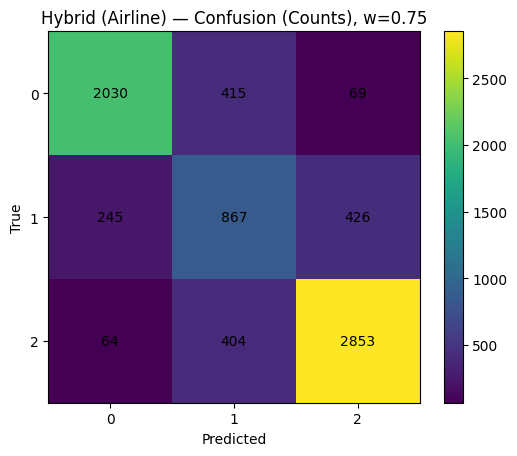

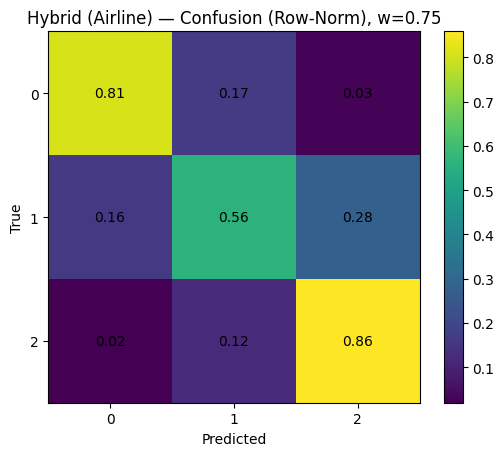

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, classification_report

BASE = "/content/drive/MyDrive/PR_Sky"

yte = np.load(os.path.join(BASE, "airline_hybrid_y_test.npy"))

proba_g = np.load(os.path.join(BASE, "airline_hybrid_proba_g.npy"))
cls_g   = np.load(os.path.join(BASE, "airline_hybrid_classes_g.npy"))

proba_m = np.load(os.path.join(BASE, "airline_hybrid_proba_m.npy"))
cls_m   = np.load(os.path.join(BASE, "airline_hybrid_classes_m.npy"))

ALL_CLASSES = np.array(sorted(set(cls_g.tolist()) | set(cls_m.tolist())))

Pg = np.zeros((proba_g.shape[0], len(ALL_CLASSES)), dtype=float)
for j in range(len(cls_g)):
    c_val = cls_g[j]

    for ti in range(len(ALL_CLASSES)):
        if ALL_CLASSES[ti] == c_val:
            tgt_idx = ti
            break
    Pg[:, tgt_idx] = proba_g[:, j]

Pm = np.zeros((proba_m.shape[0], len(ALL_CLASSES)), dtype=float)
for j in range(len(cls_m)):
    c_val = cls_m[j]
    for ti in range(len(ALL_CLASSES)):
        if ALL_CLASSES[ti] == c_val:
            tgt_idx = ti
            break
    Pm[:, tgt_idx] = proba_m[:, j]

weights = [0.0, 0.25, 0.5, 0.75, 1.0]
records = []

best_w = None
best_acc = None
best_f1 = None
best_ll = None

for w in weights:
    P = w * Pg + (1.0 - w) * Pm
    y_pred = ALL_CLASSES[P.argmax(axis=1)]
    acc = accuracy_score(yte, y_pred)
    f1m = f1_score(yte, y_pred, average="macro")
    ll  = log_loss(yte, P, labels=ALL_CLASSES)

    records.append((w, acc, f1m, ll))

    if best_w is None:
        best_w = w
        best_acc = acc
        best_f1 = f1m
        best_ll = ll
    else:
        if ll < best_ll:
            best_w = w
            best_acc = acc
            best_f1 = f1m
            best_ll = ll

print("\n=== Hybrid (GNB+MNB) Results by weight (w*GNB + (1-w)*MNB) ===")
for w, acc, f1m, ll in records:
    print(f"w={w:.2f}  Acc={acc:.4f}  F1m={f1m:.4f}  LogLoss={ll:.4f}")

print(f"\n>>> Best blend: w={best_w:.2f}")
print(f"    Acc={best_acc:.4f}  F1m={best_f1:.4f}  LogLoss={best_ll:.4f}")

P_best = best_w * Pg + (1.0 - best_w) * Pm
y_pred_best = ALL_CLASSES[P_best.argmax(axis=1)]

print("\n=== Classification Report (Hybrid best w) ===")
print(classification_report(yte, y_pred_best, digits=4))

cm = confusion_matrix(yte, y_pred_best, labels=ALL_CLASSES)
print("\nConfusion Matrix (counts) [rows=true, cols=pred]:\n", cm)

plt.figure(figsize=(5.6, 4.6))
plt.imshow(cm, interpolation="nearest")
plt.colorbar()
plt.title("Hybrid (Airline) — Confusion (Counts), w=" + str(best_w))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(ALL_CLASSES)), ALL_CLASSES)
plt.yticks(range(len(ALL_CLASSES)), ALL_CLASSES)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.tight_layout()
plt.show()

cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(5.6, 4.6))
plt.imshow(cmn, interpolation="nearest")
plt.colorbar()
plt.title("Hybrid (Airline) — Confusion (Row-Norm), w=" + str(best_w))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(ALL_CLASSES)), ALL_CLASSES)
plt.yticks(range(len(ALL_CLASSES)), ALL_CLASSES)
for i in range(cmn.shape[0]):
    for j in range(cmn.shape[1]):
        plt.text(j, i, f"{cmn[i,j]:.2f}", ha="center", va="center")
plt.tight_layout()
plt.show()